In [1]:
# Do not modify import block, all necessary imports are included
# Our regular libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
%matplotlib inline

# this is for density plotting
from matplotlib import colorbar, colors
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import math

# for the polygon intersections
import shapely.geometry as sg
import descartes

# for plotting
import time
import warnings
warnings.filterwarnings('ignore')

import sys
 
# appending a path
sys.path.append('/scratch/project_2000789/muramarg/miniconda3/lib/python3.10/site-packages/')
 
# importing required module
import gsw

### Load the data

In [2]:
# load the libraries
ds = xr.open_dataset('/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_flt.nc')
# dg = xr.open_dataset('/scratch/project_2000789/muramarg/copied_files/waom10extend_grd.nc')

### Break it down to 1 year

In [3]:
startingidx = np.array([],dtype=int)

# slice the floats by one year
idx_arr = np.empty((2,20332),dtype=int)
x = ds.variables["Xgrid"].values
for i in range(idx_arr.shape[1]):
    # get the indices in that row in the xgrid
    thisrow = x[:,i]
    nonna = thisrow[~np.isnan(thisrow)]
    startidx = len(thisrow)-len(nonna)
    endidx = int(startidx + ((86400/900)*365))
    idx_arr[0][i] = startidx
    idx_arr[1][i] = endidx
    
    
    # see if the start idx
    startingidx = np.append(startingidx,startidx)

In [4]:
# select the initial columns of values (at all times)
all_xgrid = ds.variables['Xgrid'].values
all_ygrid = ds.variables['Ygrid'].values
all_salt = ds.variables['salt'].values
all_temp = ds.variables['temp'].values
all_depth = ds.variables['depth'].values
all_dens = ds.variables['rho'].values

# create the new grids of only single year values
xgrid = np.empty((35040,20332))
ygrid = np.empty((35040,20332))
salt = np.empty((35040,20332))
temp = np.empty((35040,20332))
depth = np.empty((35040,20332))
dens = np.empty((35040,20332))
time = np.empty((35040,20332))

# select in the ds.xgrid and ds.ygrid based on the values in the idx_arr
for i in range(idx_arr.shape[1]):
    idxs = idx_arr[:,i]
    thisx = all_xgrid[:,i][idxs[0]:idxs[1]]
    thisy = all_ygrid[:,i][idxs[0]:idxs[1]]
    thissalt = all_salt[:,i][idxs[0]:idxs[1]]
    thistemp = all_temp[:,i][idxs[0]:idxs[1]]
    thisdept = all_depth[:,i][idxs[0]:idxs[1]]
    thisdens = all_dens[:,i][idxs[0]:idxs[1]]
    
    # add these values to our new xgrid and ygrid for one year
    xgrid[:,i] = thisx
    ygrid[:,i] = thisy
    salt[:,i] = thissalt
    temp[:,i] = thistemp
    depth[:,i] = thisdept
    dens[:,i] = thisdens

### Select which of these are starting in polynyas

In [5]:
# get the recorded times in the history file
ds2 = xr.open_dataset('/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_his_0001.nc')
his_times = ds2.variables["ocean_time"].values[:12]
# make the array whether it is in a polynya
releasept = np.stack((xgrid[0],ygrid[0])).T                     # points where floats are released
release_time = ds.coords["ocean_time"].values[startingidx]      # corresponding dates of release
# find nearest time value in his_times of release_time
for i in range(len(release_time)):
    value = release_time[i]
    nearest = np.searchsorted(his_times, value, side="right")
    release_time[i] = his_times[nearest]
# get the index in exists for the month in which the point is released
monthi = np.array([int(str(np.datetime64(i,'M'))[-2:])-1 for i in release_time])

exists = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/polynya_seasons.txt",sep=",").reshape(12,391)   # yes or no does polynya exist
pts = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/unionpoints2.txt",sep=",")
pts = pts.reshape((391,2))

# write if the point is released in a polynya
ispolynya = np.array([])

In [6]:
# first see which index of the point we are referring to in pts
for pt,month in zip(releasept,monthi):
    idx = (np.intersect1d(np.where(pts[:,0] == pt[0]),np.where(pts[:,1] == pt[1])))
    thismonth = exists[month]
    ispolynya = np.append(ispolynya,thismonth[idx])

In [7]:
# plot the polynya locations with the release points each month
pol_locs = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/polynya_locs.txt",sep=",")
pol_locs = pol_locs.reshape(2,12,222)

In [8]:
ispolynya.shape

(20332,)

In [9]:
# remake xgrid, ygrid, salt, temp, depth, and dens
polidx = np.where(ispolynya == 1)[0]
xgrid = xgrid[:,polidx]
ygrid = ygrid[:,polidx]
salt  = salt[:,polidx]
temp = temp[:,polidx]
depth = depth[:,polidx]
dens = dens[:,polidx]

### Read from file

In [3]:
salt = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/salt.txt",sep=",")
temp = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/temp.txt",sep=",")
depth = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/depth.txt",sep=",")
salt = salt.reshape((35040,-1))
temp = temp.reshape((35040,-1))
depth = depth.reshape((35040,-1))

In [3]:
# write these to files? does this save time
xgrid = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/xgrid.txt",sep=",")
ygrid = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/ygrid.txt",sep=",")

dens = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/dens.txt",sep=",")

In [4]:
xgrid = xgrid.reshape((35040,-1))
ygrid = ygrid.reshape((35040,-1))


In [5]:
# convert depth to sea pressure
long = 73.5089
lat = -66.8245
p = gsw.p_from_z(z=depth,lat=-66.8245)


# convert the absolute salinity from practical salinity
SA = gsw.SA_from_SP(salt,p,long,lat)    # absolute salinity from practical salinity

# convert potential T to conservative T
CT = gsw.CT_from_pt(SA,temp)   # conservative T from potential T

# find the potential density from SA, CT, p
rho_pot = gsw.rho(SA,CT,p) - 1000

In [6]:
p0 = np.zeros(depth.shape)
SA0 = gsw.SA_from_SP(salt,p0,long,lat)    # absolute salinity from practical salinity

### Create the equivalent of wmt_file_year4.txt

In [7]:
# write a function to transfer neutral density to potential density based on the files
def find_nearest(array, value):
    if value == 0:
        idx = 0
    else:
        floor = math.floor(value)
        # see if we choose the 0.5 value or the 0 value
        if value>(floor+0.5):
            # choose 0.5 value
            searchval = floor+0.5
        else:
            searchval = floor
        idx = np.abs(array - searchval).argmin()
    return idx
def pot_to_neut(salt,temp):
    '''
    inputs: temp, salt arrays
    outputs: pot_rho: an array of the potential density values
    '''
    # write the arrays of values and their equivalents
    pot_grp = np.array([25  ,25.5,26  ,26.5,27  ,27.5,28,28.5])
    neut_grp = np.array([24.95,25.5,26.1,26.7,27.3,28  ,29,29.2])
    
    # create the potential density array in the same way as TS plots are created
    pot_dens = np.array([])
    for s,t in zip(salt,temp):
        dens=gsw.rho(s,t,0) -1000
        #if dens>28:
        #    print(s,t)
        pot_dens = np.append(pot_dens,dens)
        
    # transfer this to the neutral density array based on the image in the file
    neut_dens = np.array([])
    for rho in pot_dens:
        # find the idx of the nearest lower in the neut_grp
        if not np.isnan(rho):
            idx = find_nearest(pot_grp,rho)

            # get the difference between rho and neut_grp[idx], what percent is this of idx and idx+1
            diff = rho - pot_grp[idx]
            perc = diff/(pot_grp[idx+1]-pot_grp[idx])

            # get the equivalent value in the other list and calculate neutral density
            add = perc*(neut_grp[idx+1]-neut_grp[idx])
            newval = neut_grp[idx]+add
        else:
            newval = np.nan
        neut_dens = np.append(neut_dens,newval)
        
    return neut_dens

In [8]:
# coding 0 AABW, 1 MCDW, 2 ISW, 3 DSW, 4 AASW, 5 other, 6 HSSW, 7 is LSSW, 8 is mSW
def wmt_categorize2(temp,Freez_temp,salt,enddens_allvals,depth,dens):
    mass = np.array([],dtype=int)
    highd = 0
    lowd = 0
    for t,tf,s,rho,d,pd in zip(temp,Freez_temp,salt,enddens_allvals,depth,dens):
        # aabw
        if d <= -1066.8 and rho >= 28.27 and s>=34.6 and s<=34.75 and t<=0:
            mass = np.append(mass,0)
            
        # shelf waters
        #mSW
        elif rho >= 28.27 and s >=34.5 and t>(tf+0.1) and t<-1.7 and (d>-1000):
            mass = np.append(mass,8)
            
        # dsw
        elif s>=34.5 and t>=(tf-0.5) and t<=(tf+0.1) and rho>=28.27:
            mass = np.append(mass,3)
        # hssw is before we reach conditions for dsw
        elif pd>=28 and (s>34.5) and (d>-1000) and t<-1.7 and t>-2: # from Yoon, Portela and 
            # add it to the list of indices of interest
            mass = np.append(mass,6)
        # lssw is from conditions too low salinity for dsw
        elif pd >= 28 and s<=34.5 and (d>-1000) and t<-1.7 and t>-2:
            mass = np.append(mass,7)
        
        # other water masses defined from portela
        # mcdw
        elif t>(tf+0.1) and rho>=28 and rho<=28.27:                             # modified tf
            mass = np.append(mass,1)
        # aasw
        elif s<=34.5 and t>=tf and rho<28:                                          # modified s
            mass = np.append(mass,4)
        # isw (also defined in yoon)
        elif t<(tf) and d<-100:                                                    # modified tf
            mass = np.append(mass,2)
        
        # other
        else:
            #if rho>28 and t>tf:
            mass = np.append(mass,5)
                
            #print(t,tf,s,rho,d,pd)
            #else:
            #    do = 1
                #print(t,tf,s,rho,d)
    return(mass)

In [9]:
dens = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/dens.txt",sep=",")
dens = dens.reshape((35040,-1))

In [10]:
# # # code an entire array of values of the water mass type the same shape as ds.variables['x'].shape (65717,5460)
#wm_arr = np.empty((35040,5460))
start_time = time.time()

wmt = np.zeros(((35040,6586)))

for i in range(35040): 
#for i in range(5):
    if i%3000 == 0:
        print(i,"/",35040,"in",(time.time()-start_time)/60)
    # get the array values
    thistemp = CT[i]
    thissalt = SA[i]
    thisdepth = depth[i]
    thisdens = dens[i]
    #thisgamma = gamma_n[i]

    SA_salt = SA0[i]
    # get the neutral density values
    end_dens = pot_to_neut(thissalt,thistemp)
    # characterize each value in the array
    Freez_temp = gsw.CT_freezing(SA_salt,0,0)
    
    wm_mass = wmt_categorize2(thistemp,Freez_temp,thissalt,end_dens,thisdepth,thisdens)
    wmt[i] = wm_mass
wmt.tofile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/wm_file_year_v2.txt",sep=",")

0 / 35040 in 5.372365315755209e-06
3000 / 35040 in 11.065595491727192
6000 / 35040 in 22.15033299922943
9000 / 35040 in 33.23926674922307
12000 / 35040 in 44.35539143880208
15000 / 35040 in 55.46649122238159
18000 / 35040 in 66.5707061211268
21000 / 35040 in 77.68292644023896
24000 / 35040 in 88.80893572568894
27000 / 35040 in 99.9634688337644
30000 / 35040 in 111.10561192830404
33000 / 35040 in 122.23542272647222


### Create the equivalent of wmt4.txt

tmin, tmax, smin, smax sizes=, -3.3 3.63 30.69 38.38


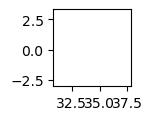

In [4]:
# add the polygons and the points
smin = 31 - (0.01 * 31)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 38. + (0.01 * 38.)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -3 + (0.1 * -3)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 3.3 + (0.1 * 3.3)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 30
ydim = 30
# Create empty grid of zeros
dens2 = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti1 = np.linspace(-3,3.3,ydim)
si1 = np.linspace(31,38,xdim)
Freez_temp = gsw.CT_freezing(si1,0,0)

Si, Ti = np.meshgrid(si1, ti1, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens2[j,i]=gsw.rho(si1[i],ti1[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens2 - 1000

# convert to practical/potential
long = 73.5089
lat = -66.8245
ti = gsw.pt_from_CT(si1,ti1)
si = gsw.SP_from_SA(si1,0,long,lat)

# create the polygons for the next plot
fig = plt.figure(figsize=(1,1))
ax = fig.add_subplot(1, 1, 1)

# add aabw values
cs = ax.contourf(si, ti, dens2, levels=[27.82,31],colors="black", zorder=1,alpha=0,linestyles='-.')
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.2f")
# get the dens2ity vertices
p = cs.collections[0].get_paths()[0]
v = p.vertices
# get the TS vertices
s = np.array([34.5,36,36,34.5,34.5])
t = np.array([-3,-3,0.1,0.1,-3])
b = np.array([[a,b] for a,b in zip(s,t)])
# # find intersection and plot
a = sg.Polygon(v)
b = sg.Polygon(b)
ft = Freez_temp
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[0.1,0.1,max(ft)])
c = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(c)
d = a.intersection(b)
aabw = c.intersection(d)

# find the winter water values
cs = ax.contourf(si, ti, dens2, levels=[27.55,27.73],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
ft = Freez_temp
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[-1.5,-1.5,max(ft)])
b = np.array([[a,b] for a,b in zip(si2,ft)])
a = sg.Polygon(v)
b = sg.Polygon(b)
ww = a.intersection(b)

# find the mcdw values
cs = ax.contourf(si, ti, dens2, levels=[27.73,27.82],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
ft = Freez_temp
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[1.5,1.5,max(ft)])
b = np.array([[a,b] for a,b in zip(si2,ft)])
a = sg.Polygon(v)
b = sg.Polygon(b)
mcdw = a.intersection(b)

# find the dsw values
cs = ax.contourf(si, ti, dens2, levels=[27.82,31],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)
# ftmax = Freez_temp+0.1
# ftmin = Freez_temp-0.5
# ft = np.append(ftmax,np.flip(ftmin))
# si2 = si.copy()
# si2 = np.append(si2,np.flip(si2))
# b = np.array([[a,b] for a,b in zip(si2,ft)])
sx = np.array([35,35,34.5,34.5])
sy = np.array([-3,-1.7,-1.7,-3])
ss = np.array([[a,b] for a,b in zip(sx,sy)])
b = sg.Polygon(ss)             # second shape in salinity
#dsw = b.intersection(c)
dsw = b.intersection(a)

# find the aasw values
cs = ax.contourf(si, ti, dens2, levels=[24,27.73],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)              # first shape in dens2ity
sx = np.array([34.5,34.5,31,31])
sy = np.array([-3,3.5,3.5,-3])
ss = np.array([[a,b] for a,b in zip(sx,sy)])
b = sg.Polygon(ss)             # second shape in salinity
ft = Freez_temp
ft = np.append(ft,[3.5,3.5])
si2 = si.copy()
si2 = np.append(si2,[35,31])
ta = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(ta)              # third shape in temperature
d = b.intersection(c)
aasw = d.intersection(a)

# find the msw values
cs = ax.contourf(si, ti, dens2, levels=[27.82,31],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)
ft = Freez_temp + 0.1
ft = np.append(ft,[-0.4,-0.4])
si2 = si.copy()
si2 = np.append(si2,[35,31])
ta = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(ta)              # third shape in temperature
#dsw = b.intersection(c)
msw = c.intersection(a)
msw = msw.difference(dsw)

# add ISW values
cs = ax.contourf(si, ti, dens2, levels=[25,27.82],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)
ft = Freez_temp# - 0.05
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[-3,-3,max(ft)])
b = np.array([[a,b] for a,b in zip(si2,ft)])
b = sg.Polygon(b)
isw = b.intersection(a)
#isw = isw.difference(dsw)
isw = isw.difference(aabw)
#ucdw = ucdw.difference(mcdw)
aasw = aasw.difference(ww)
#aasw = aasw.difference(ucdw)

# find the aaiw values
cs = ax.contourf(si, ti, dens2, levels=[27.2,27.4],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)              # first shape in dens2ity
sx = np.array([34.6,34.6,32,32])
sy = np.array([2,3.5,3.5,2])
ss = np.array([[a,b] for a,b in zip(sx,sy)])
b = sg.Polygon(ss)             # second shape in salinity
ft = Freez_temp
ft = np.append(ft,[3.5,3.5])
si2 = si.copy()
si2 = np.append(si2,[35,31])
ta = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(ta)              # third shape in temperature
d = b.intersection(c)
aaiw = d.intersection(a)

In [5]:
T_wdw = -2.05
S_wdw = 34.5
Lf = 334 # kJ/kg
Cp = gsw.cp_t_exact(S_wdw,T_wdw,0)/1000
print(Cp)

Tgade = T_wdw + (Lf/Cp)*(1 - (S_wdw/si))

3.9907110140574806


Text(0, 0.5, 'Potential Temperature')

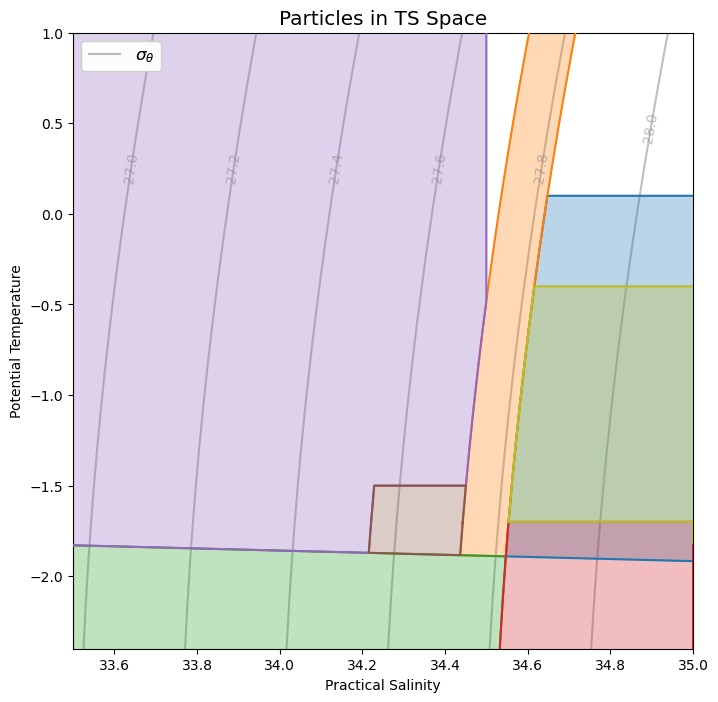

In [6]:
#POLYGONS
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
plt.ylim(-2.4,1)
plt.xlim(33.5,35)
#plt.xlim(xedges[0], xedges[-1])
#plt.ylim(yedges[0], yedges[-1])
shapes = np.array([])
shapelabels = np.array([])
plt.rcParams.update({'font.size': 12})

# add the potential density lines
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1,alpha=0.5,levels=np.arange(24,28.5,0.2))
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.1f")
h, l = cs.legend_elements()
h = np.array([h[0]],dtype=object)
l = np.array(["$\sigma_{θ}$"])

# AABW values
x, y = aabw.exterior.xy
aabw2 = plt.plot(x, y,label="AABW",color="tab:blue",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:blue")
shapes = np.append(shapes,aabw2)
shapelabels = np.append(shapelabels,"AABW*")
# MCDW values
x, y = mcdw.exterior.xy
mcdw2 = plt.plot(x, y,label="mCDW",color="tab:orange",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:orange")
shapes = np.append(shapes,mcdw2)
shapelabels = np.append(shapelabels,"mCDW")

# # ISW values
x, y = isw.exterior.xy
isw2 = plt.plot(x, y,label="ISW",color="tab:green",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:green")
shapes = np.append(shapes,isw2)
shapelabels = np.append(shapelabels,"ISW")
# # DSW values
x, y = dsw.exterior.xy
dsw2 = plt.plot(x, y,label="DSW",color="tab:red",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:red")
shapes = np.append(shapes,dsw2)
shapelabels = np.append(shapelabels,"DSW")

# # MSW values
x, y = msw.exterior.xy
msw2 = plt.plot(x, y,label="mSW*",color="tab:olive",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:olive")
shapes = np.append(shapes,msw2)
shapelabels = np.append(shapelabels,"mSW*")

# # AASW values
x, y = aasw.exterior.xy
aasw2 = plt.plot(x, y,label="AASW",color="tab:purple",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:purple")
shapes = np.append(shapes,aasw2)
shapelabels = np.append(shapelabels,"AASW")

# # WW values
x, y = ww.exterior.xy
ww2 = plt.plot(x, y,label="WW",color="tab:brown",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:brown")
shapes = np.append(shapes,ww2)
shapelabels = np.append(shapelabels,"WW")

# labels and plot
legend1 = plt.legend(h,l, loc=2)
plt.gca().add_artist(legend1)
#plt.legend(shapes,shapelabels, loc=1)
# plt.scatter(salt.flatten(),temp.flatten(),s=0.1)

# plt.title("Neutral and potential density of water masses")
plt.title("Particles in TS Space")
plt.xlabel('Practical Salinity')
plt.ylabel('Potential Temperature')

In [7]:
from shapely import Point

In [ ]:
# testing point is in polygon

In [21]:
# coding 0 AABW, 1 MCDW, 2 ISW, 3 DSW, 4 AASW, 5 other, 6 is CDW, 8 is mSW
# use potential T and practical S, 
def wmt_categorize2(temp,salt,depth,aabw,mcdw,isw,dsw,aasw,ww,msw):
#     print(temp.shape,Freez_temp.shape,salt.shape,enddens_allvals.shape,depth.shape,dens.shape)
    mass = np.array([],dtype=int)
    highd = 0
    lowd = 0
    for t,s,d in zip(temp,salt,depth):
        point = Point(s,t)
        
        # aabw
        if d<-1000 and aabw.contains(point):
            mass = np.append(mass,0)
        elif d>-1000 and msw.contains(point):
            mass = np.append(mass,6)
            
        # mcdw
        elif mcdw.contains(point): # or aabw.contains(point):                             # modified tf
            mass = np.append(mass,1)

        # dsw
        elif dsw.contains(point):
            #elif s>=34.5 and t>=(tf-0.5) and t<=(tf+0.1) and rho>=27.68:
            mass = np.append(mass,3)
            
        # isw (also defined in yoon)
        elif isw.contains(point):                                                    # modified tf
            mass = np.append(mass,2)
        # other water masses defined from portela
        # aasw
        elif aasw.contains(point):                                          # modified s
            mass = np.append(mass,4)
        # ww
        elif ww.contains(point):
            mass = np.append(mass,5)
        
        # other shelf waters
        elif aabw.contains(point):
            mass = np.append(mass,6)
        
        else:
            mass = np.append(mass,1)
        
    return(mass)

In [22]:
# # # code an entire array of values of the water mass type the same shape as ds.variables['x'].shape (65717,5460)
#wm_arr = np.empty((35040,5460))
start_time = time.time()

wmt = np.zeros(((35040,6586)))

for i in range(35040): 
#for i in range(35034,35040):
#for i in range(12000,12006):
    if i%3000 == 0:
        print(i,"/",35040,"in",(time.time()-start_time)/60)
    # get the array values
    thistemp = CT[i]
    thissalt = SA[i]
    thisdepth = depth[i]
    
    #thisdens = dens[i]
    #thisgamma = gamma_n[i]
    #SA_salt = SA0[i]
    # get the neutral density values
    #end_dens = pot_to_neut(thissalt,thistemp)
    # characterize each value in the array
    #Freez_temp = gsw.CT_freezing(SA_salt,0,0)
    
    wm_mass = wmt_categorize2(thistemp,thissalt,thisdepth,aabw,mcdw,isw,dsw,aasw,ww,msw)
    wmt[i] = wm_mass
    
wmt.tofile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/wmt3.txt",sep=",")

0 / 35040 in 1.2334187825520834e-05
3000 / 35040 in 13.555259037017823
6000 / 35040 in 28.095310151576996
9000 / 35040 in 42.441209916273756
12000 / 35040 in 55.99570704301198
15000 / 35040 in 68.80476102431615
18000 / 35040 in 81.13961952924728
21000 / 35040 in 93.2216902812322
24000 / 35040 in 105.18542211055755
27000 / 35040 in 117.10620989402135
30000 / 35040 in 129.05466686089832
33000 / 35040 in 141.00360462268193


### reread the files and rewrite as a new wmt file

In [12]:
wmtgamman = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/wm_file_year_v2.txt",sep=",")
wmtgamman = wmtgamman.reshape((35040,6586))

#wmtgamman[wmtgamman == 6] = 3
wmtgamman[wmtgamman == 7] = 2
#wmtgamman[wmtgamman == 8] = 6

wmtpolygon = np.fromfile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/wmt2.txt",sep=",")
wmtpolygon = wmtpolygon.reshape((35040,6586))

wmtpolygon[wmtgamman == 2] = 2
wmtpolygon[wmtgamman == 1] = 1

In [34]:
thismass = wmtgamman.flatten()
unique_elements, counts_elements = np.unique(thismass, return_counts=True)
print(unique_elements)
print(counts_elements)

[0. 1. 2. 3. 4. 5. 8.]
[    39783  13765354    452583  57565349   3990215 137546082  17414074]


In [ ]:
thismass = wmt[10000]
unique_elements, counts_elements = np.unique(thismass, return_counts=True)
print(unique_elements)
print(counts_elements)

In [39]:
wmtpolygon.tofile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/wmt_final.txt",sep=",")

### Check the value counts for the final tally

In [70]:
thismass = wmtgamman[15000]
unique_elements, counts_elements = np.unique(thismass, return_counts=True)
print(unique_elements)
print(counts_elements)

[1. 2. 3. 4. 5. 8.]
[ 365   12 1495   83 4120  511]


In [23]:
x=5

In [25]:
# test to make sure we're plotting the right ones as isw

In [30]:
ds1 = xr.open_dataset('/scratch/project_2000789/muramarg/waom_total/output_WAOM_check/ocean_avg_0016.nc')

In [76]:
isw2 = np.where(thismass==2)
isw2[0].shape

(12,)

In [77]:
dsw2 = np.where(thismass==3)
dsw2[0].shape

(1495,)

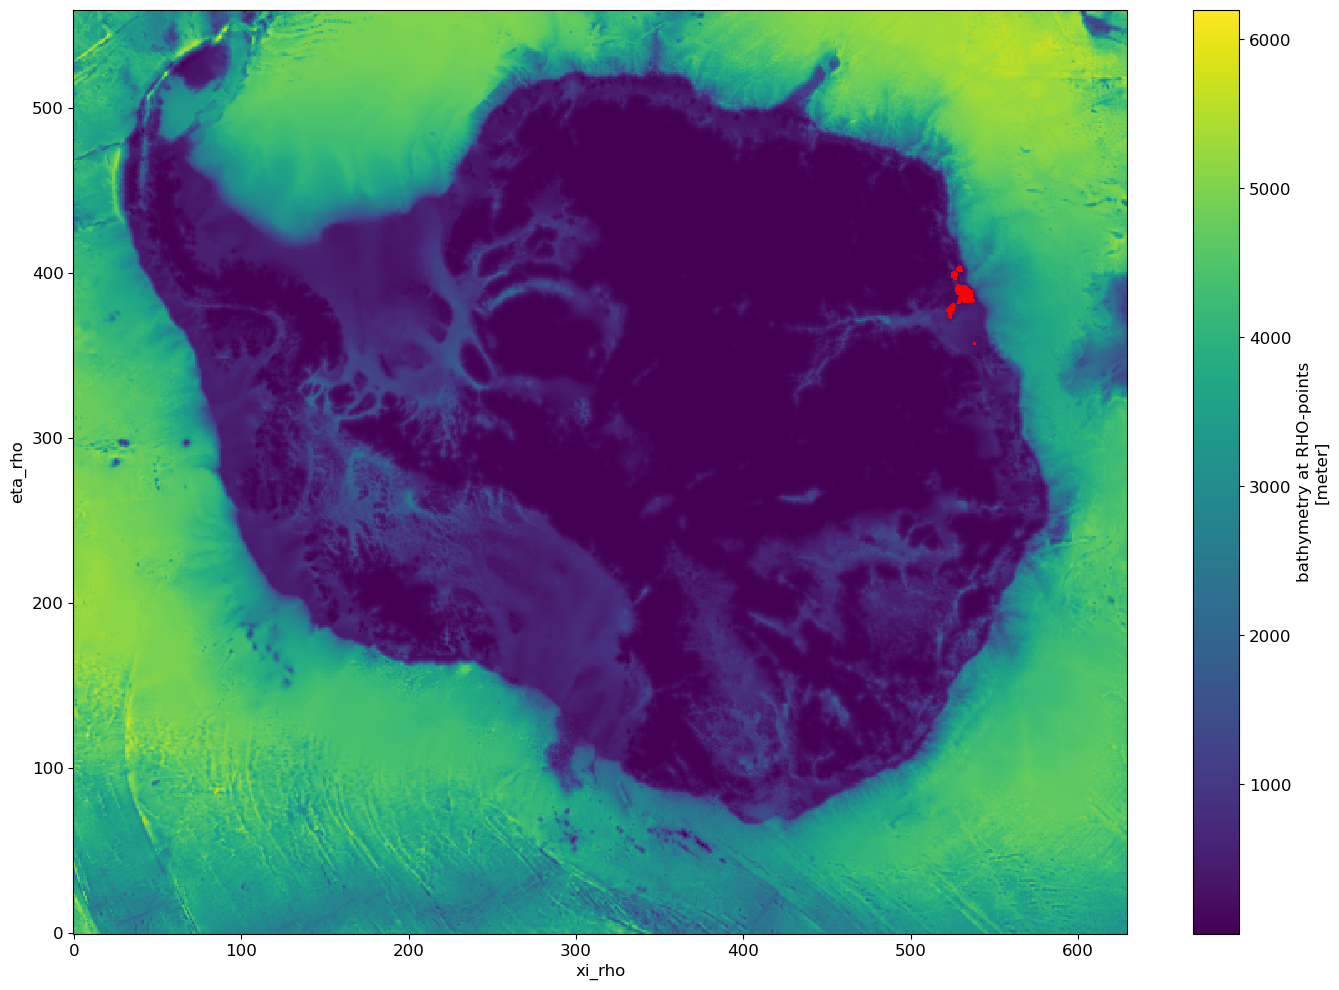

In [100]:
fig = plt.figure(figsize=(17,12))
ds1.h.isel().plot()
x = xgrid.flatten()
y = ygrid.flatten()
wmt_test = wmtpolygon.flatten()
plt.plot(x[np.where(mass==3)],y[np.where(mass==3)],'.',markersize=2, color='r')

In [61]:
saltflat = salt.flatten()
tempflat = temp.flatten()

In [79]:
# coding 0 AABW, 1 MCDW, 2 ISW, 3 DSW, 4 AASW, 5 other, 6 is CDW, 8 is mSW
# use potential T and practical S, 
def wmt_categorize2(temp,salt,depth,aabw,mcdw,isw,dsw,aasw,ww,msw):
#     print(temp.shape,Freez_temp.shape,salt.shape,enddens_allvals.shape,depth.shape,dens.shape)
    mass = np.array([],dtype=int)
    highd = 0
    lowd = 0
    for t,s,d in zip(temp,salt,depth):
        point = Point(s,t)
        
        # aabw
        if d<-1000 and aabw.contains(point):
            mass = np.append(mass,0)
        elif d>-1000 and msw.contains(point):
            mass = np.append(mass,6)
            
        # mcdw
        elif mcdw.contains(point): # or aabw.contains(point):                             # modified tf
            mass = np.append(mass,1)

        # dsw
        elif dsw.contains(point):
            #elif s>=34.5 and t>=(tf-0.5) and t<=(tf+0.1) and rho>=27.68:
            mass = np.append(mass,3)
            
        # isw (also defined in yoon)
        elif isw.contains(point):                                                    # modified tf
            mass = np.append(mass,2)
        # other water masses defined from portela
        # aasw
        elif aasw.contains(point):                                          # modified s
            mass = np.append(mass,4)
        # ww
        elif ww.contains(point):
            mass = np.append(mass,5)
        
        # other shelf waters
        elif aabw.contains(point):
            mass = np.append(mass,6)
        
        else:
            mass = np.append(mass,1)
        
    return(mass)

In [9]:
saltflat = salt.flatten()
tempflat = temp.flatten()

In [10]:
msw.contains(Point(saltflat[10],tempflat[10]))

False

In [12]:
depthflat = depth.flatten()

In [20]:
points = []

In [21]:
# # # code an entire array of values of the water mass type the same shape as ds.variables['x'].shape (65717,5460)
#wm_arr = np.empty((35040,5460))
start_time = time.time()

mass = np.zeros(depthflat.shape)
names = np.array(["AABW","mCDW","ISW","DSW","AASW","WW","mSW"])

# for point,d in zip(points,depth.flatten()):
for i in range(len(depthflat)):
    
    point = Point(saltflat[i],tempflat[i])
    d = depthflat[i]
    
    if i%5000000 == 0:
        print(str(i),"/",str(saltflat.shape[0]),"in",(time.time()-start_time)/60)
        
    # aabw
    if d<-1000 and aabw.contains(point):
        val = 0
    elif d>-1000 and msw.contains(point):
        val=6
            
    # mcdw
    elif mcdw.contains(point): # or aabw.contains(point):                             # modified tf
        val=1

    # dsw
    elif dsw.contains(point):
        #elif s>=34.5 and t>=(tf-0.5) and t<=(tf+0.1) and rho>=27.68:
        val=3
            
    # isw (also defined in yoon)
    elif isw.contains(point):                                                    # modified tf
        val=2
        
    # other water masses defined from portela
    # aasw
    elif aasw.contains(point):                                          # modified s
        val=4
    # ww
    elif ww.contains(point):
        val=5
        
    # other shelf waters
    elif aabw.contains(point):
        val=6
        
    else:
        # mcdw
        val=1
        
    mass[i] = val
    


0 / 230773440 in 1.0251998901367188e-05
5000000 / 230773440 in 3.453112800916036
10000000 / 230773440 in 6.936282745997111
15000000 / 230773440 in 10.524437630176545
20000000 / 230773440 in 14.2384490331014
25000000 / 230773440 in 18.04627933104833
30000000 / 230773440 in 21.832076239585877
35000000 / 230773440 in 25.565008413791656
40000000 / 230773440 in 29.21952118873596
45000000 / 230773440 in 32.85850377480189
50000000 / 230773440 in 36.46164468129476
55000000 / 230773440 in 40.08045649925868
60000000 / 230773440 in 43.668579109509785
65000000 / 230773440 in 47.27803401947021
70000000 / 230773440 in 50.879508996009825
75000000 / 230773440 in 54.48227954308192
80000000 / 230773440 in 58.00569978952408
85000000 / 230773440 in 61.52582707007726
90000000 / 230773440 in 64.96551148891449
95000000 / 230773440 in 68.41349475383758
100000000 / 230773440 in 71.81933045784632
105000000 / 230773440 in 75.22118372122446
110000000 / 230773440 in 78.60271149079004
115000000 / 230773440 in 81.95

NameError: name 'wmt' is not defined

In [22]:
unique_elements, counts_elements = np.unique(mass, return_counts=True)
print(counts_elements)
print(unique_elements)
    
mass.tofile("/scratch/project_2000789/muramarg/floats_WAOM/text_files/mass_wmt.txt",sep=",")

[27443871 83650577 17842169 21094593 40794098 26863626 13084506]
[0. 1. 2. 3. 4. 5. 6.]


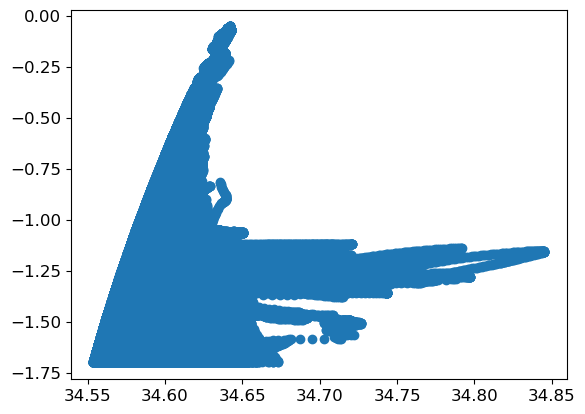

In [24]:
wmt_test = np.where(mass==6)
plt.scatter(saltflat[:len(mass)][wmt_test],tempflat[:len(mass)][wmt_test])

In [25]:
mass = mass.reshape(35040,-1)
mass.shape

(35040, 6586)